In [414]:
import os
os.chdir(os.getcwd())

## Import Module

In [415]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Import Data

In [416]:
df = pd.read_excel('process_data/part4_data.xlsx',sheet_name="Sheet1")
df.head()

,year,Life Expectancy,Mobile
0,1990,70.248,0.111784
1,1991,70.300,0.215876
2,1992,70.281,0.433454
3,1993,70.239,0.708901
4,1994,70.202,1.252280


In [417]:
df['year'] = pd.to_datetime(df['year'], format="%Y")

In [418]:
#df['year'] = pd.to_datetime(df['year'])
df.set_index('year',inplace=True)
df.head()

,Life Expectancy,Mobile
year,,
1990-01-01,70.248,0.111784
1991-01-01,70.300,0.215876
1992-01-01,70.281,0.433454
1993-01-01,70.239,0.708901
1994-01-01,70.202,1.252280


In [419]:
df.index

DatetimeIndex(['1990-01-01', '1991-01-01', '1992-01-01', '1993-01-01',
               '1994-01-01', '1995-01-01', '1996-01-01', '1997-01-01',
               '1998-01-01', '1999-01-01', '2000-01-01', '2001-01-01',
               '2002-01-01', '2003-01-01', '2004-01-01', '2005-01-01',
               '2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01',
               '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01',
               '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01',
               '2018-01-01', '2019-01-01'],
              dtype='datetime64[ns]', name='year', freq=None)

## Timeseries Decomposition

<AxesSubplot:xlabel='year'>

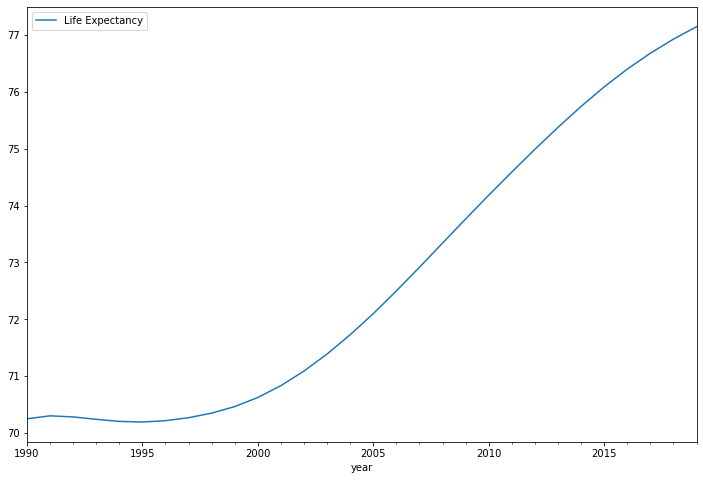

In [420]:
df[['Life Expectancy']].plot(figsize=(12,8))

<AxesSubplot:xlabel='year'>

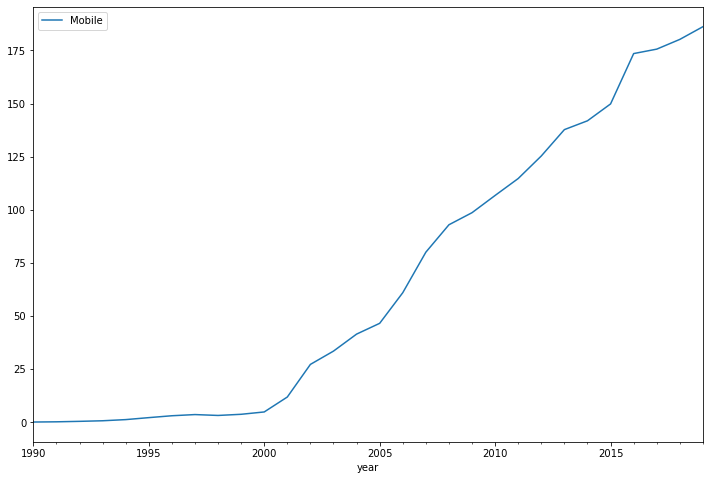

In [421]:
df[['Mobile']].plot(figsize=(12,8))

<AxesSubplot:xlabel='year'>

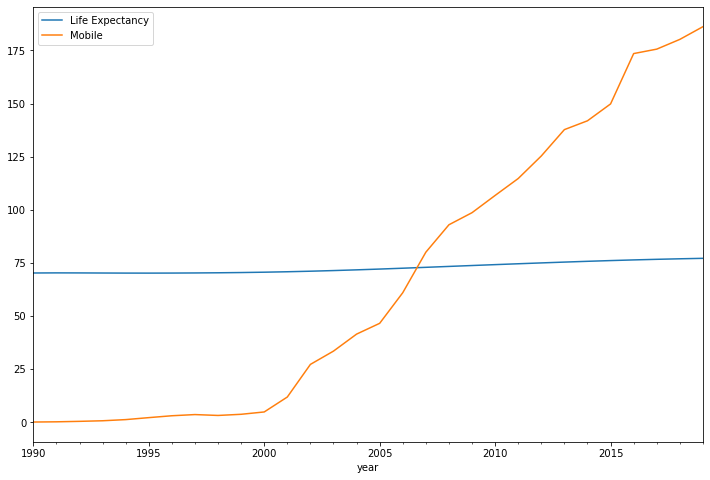

In [422]:
df.plot(figsize=(12,8))

<Figure size 432x288 with 0 Axes>

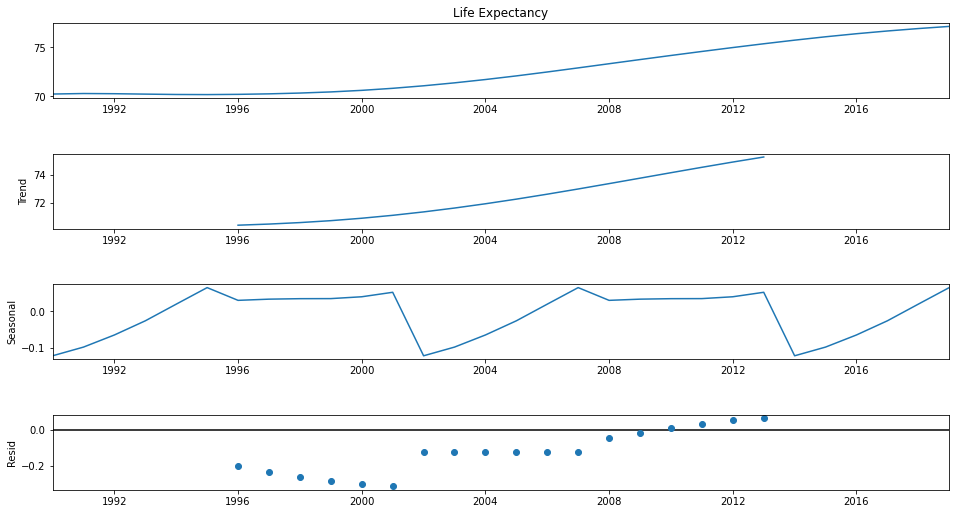

In [423]:
# From the plot above, we can see that seasonal pattern lasts for 12 months (1 year)
seasonal_period = 12
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Life Expectancy'], period=seasonal_period)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

<Figure size 432x288 with 0 Axes>

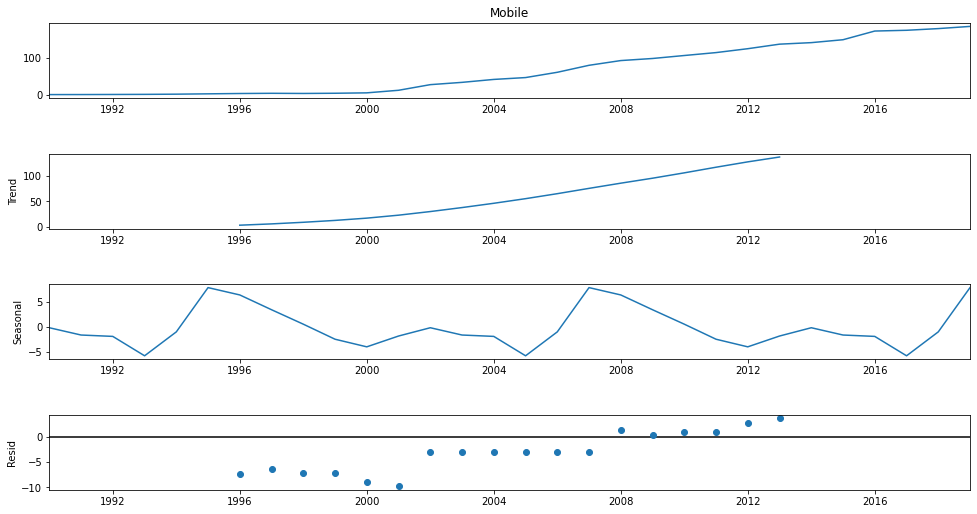

In [424]:
decomposition = seasonal_decompose(df['Mobile'], period=seasonal_period)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

## Life Expectancy

#### Check Stationary, Autocorrelation (ACF), Partial Correlation (PACF)

In [425]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['Life Expectancy'])
result

(-1.4903041306828781,
 0.538302178026433,
 3,
 26,
 {'1%': -3.7112123008648155,
  '5%': -2.981246804733728,
  '10%': -2.6300945562130176},
 -179.40641766041668)

In [426]:
def check_adfuller(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("Reject the null hypothesis. Data is stationary")
    else:
        print("Do not reject the null hypothesis. Data is not stationary ")

In [427]:
check_adfuller(df['Life Expectancy'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.4903041306828781
p-value : 0.538302178026433
#Lags Used : 3
Number of Observations Used : 26
Do not reject the null hypothesis. Data is not stationary 


<AxesSubplot:xlabel='year'>

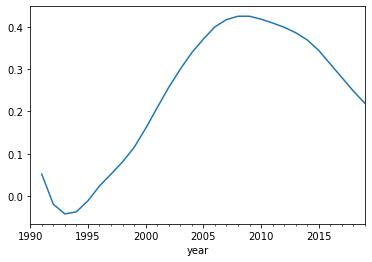

In [428]:
# Since the original timeseries is not stationary, we derive the first-order differenced series
df['First Difference'] = df['Life Expectancy'] - df['Life Expectancy'].shift(1)
df['First Difference'].plot()

In [429]:
# Check whether the first-order differenced series is stationary
check_adfuller(df['First Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.7839924506959541
p-value : 0.38843745644241506
#Lags Used : 8
Number of Observations Used : 20
Do not reject the null hypothesis. Data is not stationary 


In [430]:
# Since the first-order differenced series is stationary, we set difference parameter (d) = 1
d = 1

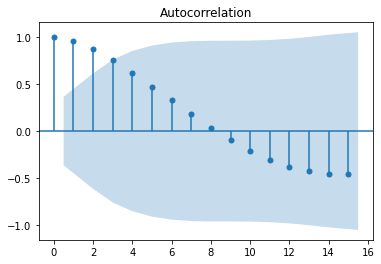

In [431]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig_first_acf = plot_acf(df["First Difference"].dropna())

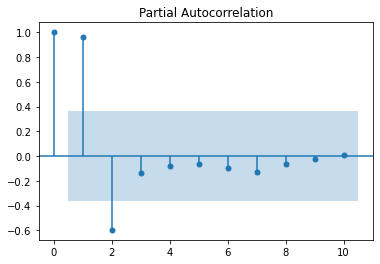

In [432]:
fig_first_pacf = plot_pacf(df["First Difference"].dropna(), lags=10, method='ywmle')

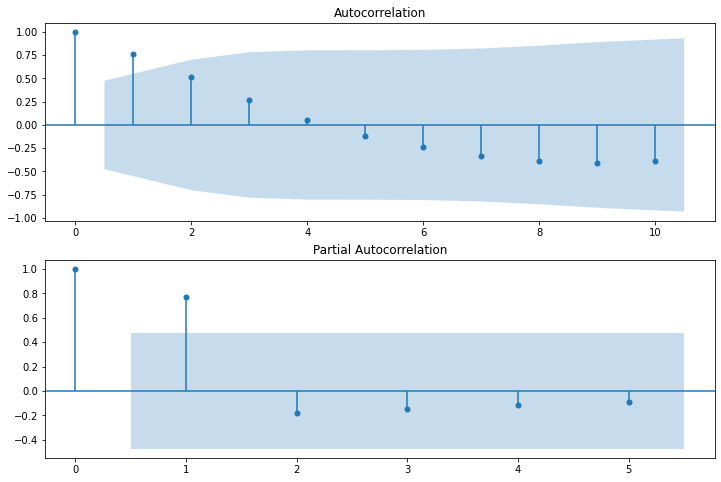

In [433]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['First Difference'].iloc[13:], lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['First Difference'].iloc[13:], method='ywmle', lags=5, ax=ax2)

In [434]:
from statsmodels.tsa.stattools import acf,pacf
df_pacf = pacf(df["First Difference"].dropna(), nlags=10 ,method='ols')
for i in range(0, len(df_pacf)):
    if df_pacf[i] < 1.96 / np.sqrt(len(df['Life Expectancy'])):
        print("p= ", i-1)
        break

p=  1


In [435]:
df_acf = acf(df['Life Expectancy'], fft= True)
for i in range(0, len(df_acf)):
    if df_acf[i] < 1.96 / np.sqrt(len(df['Life Expectancy'])):
        print("q= ", i-1)
        break

q=  6


/Users/pantchanit/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


In [436]:
# From ACF and PACF plots of seasonal part of timeseries, we set p = 2, and q = 2
p = 2
q = 2

#### ARIMA Model

In [437]:
print(p)
print(d)
print(q)

2
1
2


In [438]:
from statsmodels.tsa.arima.model import ARIMA
# Time index for ARIMA input must have freq parameter set.  
df = df.asfreq(df.index.inferred_freq, method='ffill')
# Run ARIMA 
model = ARIMA(df['Life Expectancy'].dropna(), order=(p,d,q))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:        Life Expectancy   No. Observations:                   30
Model:                 ARIMA(2, 1, 2)   Log Likelihood                  91.148
Date:                Thu, 07 Apr 2022   AIC                           -172.296
Time:                        21:33:57   BIC                           -165.459
Sample:                    01-01-1990   HQIC                          -170.154
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9656      0.049     40.399      0.000       1.870       2.061
ar.L2         -0.9769      0.065    -15.010      0.000      -1.104      -0.849
ma.L1          0.8649      0.195      4.434      0.0

In [439]:
# Let's try ARIMA with other values of p and q
model2 = ARIMA(df['Life Expectancy'].dropna(),order=(1,d,1))
result2 = model2.fit()
print(result2.summary())

                               SARIMAX Results                                
Dep. Variable:        Life Expectancy   No. Observations:                   30
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  71.902
Date:                Thu, 07 Apr 2022   AIC                           -137.805
Time:                        21:33:57   BIC                           -133.703
Sample:                    01-01-1990   HQIC                          -136.520
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9858      0.023     43.444      0.000       0.941       1.030
ma.L1          0.9739      0.886      1.099      0.272      -0.763       2.711
sigma2         0.0003      0.000      1.130      0.2

/Users/pantchanit/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pantchanit/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [440]:
# Let's try ARIMA with other values of p and q
model3 = ARIMA(df['Life Expectancy'].dropna(),order=(0,d,0))
result3 = model3.fit()
print(result3.summary())

                               SARIMAX Results                                
Dep. Variable:        Life Expectancy   No. Observations:                   30
Model:                 ARIMA(0, 1, 0)   Log Likelihood                  -4.971
Date:                Thu, 07 Apr 2022   AIC                             11.943
Time:                        21:33:57   BIC                             13.310
Sample:                    01-01-1990   HQIC                            12.371
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0825      0.038      2.198      0.028       0.009       0.156
Ljung-Box (L1) (Q):                  29.47   Jarque-Bera (JB):                 2.96
Prob(Q):                              0.00   Pr

In [441]:
from statsmodels.tsa.arima_model import ARIMAResults 
model = ARIMA(df['Life Expectancy'].dropna(),order=(p,d,q))
result = model.fit()
print(result2.aic)
model2 = ARIMA(df['Life Expectancy'].dropna(),order=(0,d,0))
result2 = model2.fit()
print(result2.aic)
model3 = ARIMA(df['Life Expectancy'].dropna(),order=(1,d,1))
result3  =model3.fit()
print(result3.aic)
model4 = ARIMA(df['Life Expectancy'].dropna(),order=(0,d,1))
result4  =model4.fit()
print(result4.aic)
model5 = ARIMA(df['Life Expectancy'].dropna(),order=(1,d,0))
result5  =model5.fit()
print(result5.aic)

-137.8049183443837
11.942548938915934
-137.8049183443837
-22.446022482434373
-110.86426995504964


/Users/pantchanit/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pantchanit/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<AxesSubplot:xlabel='year'>

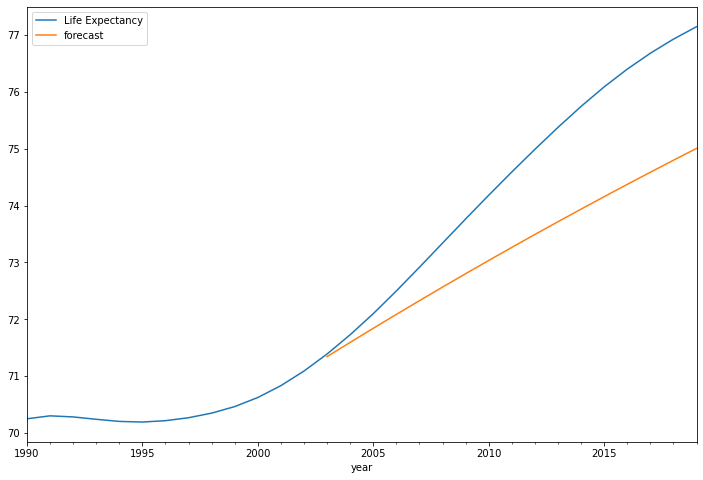

In [442]:
model5 = ARIMA(df['Life Expectancy'].dropna(),order=(1,d,0))
result5  =model5.fit()

df['forecast'] = result5.predict(start = 13, end= 30, dynamic= True)  
df[['Life Expectancy','forecast']].plot(figsize=(12,8))

In [443]:
from pandas.tseries.offsets import DateOffset
future_dates = [df.index[-1] + DateOffset(years=x) for x in range(0,10)]
future_dates

[Timestamp('2019-01-01 00:00:00'),
 Timestamp('2020-01-01 00:00:00'),
 Timestamp('2021-01-01 00:00:00'),
 Timestamp('2022-01-01 00:00:00'),
 Timestamp('2023-01-01 00:00:00'),
 Timestamp('2024-01-01 00:00:00'),
 Timestamp('2025-01-01 00:00:00'),
 Timestamp('2026-01-01 00:00:00'),
 Timestamp('2027-01-01 00:00:00'),
 Timestamp('2028-01-01 00:00:00')]

In [444]:
future_dates_df = pd.DataFrame(index=future_dates[1:],columns=df.columns)
future_df = pd.concat([df,future_dates_df])
future_df

,Life Expectancy,Mobile,First Difference,forecast
1990-01-01,70.248,0.111784,NaN,NaN
1991-01-01,70.300,0.215876,0.052,NaN
1992-01-01,70.281,0.433454,-0.019,NaN
1993-01-01,70.239,0.708901,-0.042,NaN
1994-01-01,70.202,1.252280,-0.037,NaN
1995-01-01,70.191,2.182421,-0.011,NaN
1996-01-01,70.215,3.067722,0.024,NaN
1997-01-01,70.267,3.622069,0.052,NaN
1998-01-01,70.348,3.210122,0.081,NaN
1999-01-01,70.463,3.755144,0.115,NaN


<AxesSubplot:>

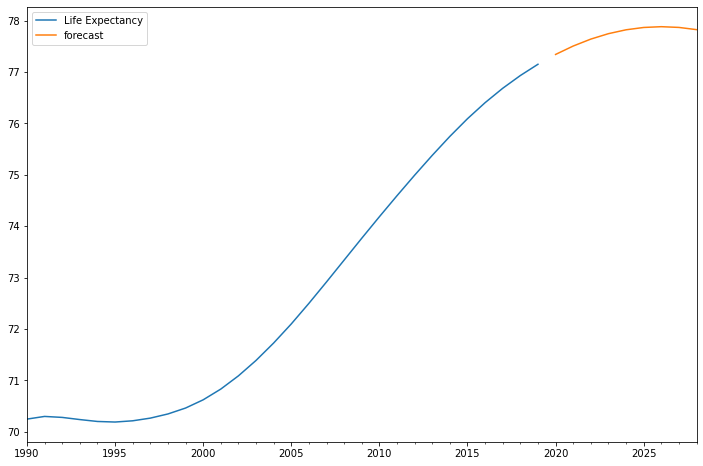

In [445]:
future_df['forecast'] = result.predict(start = 30, end = 40, dynamic= True)  
future_df[['Life Expectancy', 'forecast']].plot(figsize=(12, 8))

<AxesSubplot:xlabel='year'>

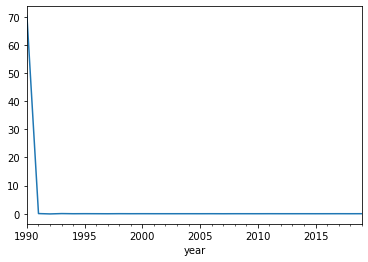

In [446]:
result.resid.plot()